In [ ]:
import cv2
import numpy as np
from skimage.metrics import mean_squared_error
from random import randrange
import matplotlib.pyplot as plt

# **Harris corner detector**

## **Further reading:**
### Medium link:
https://medium.com/@itberrios6/harris-corner-and-edge-detector-4169312aa2f8

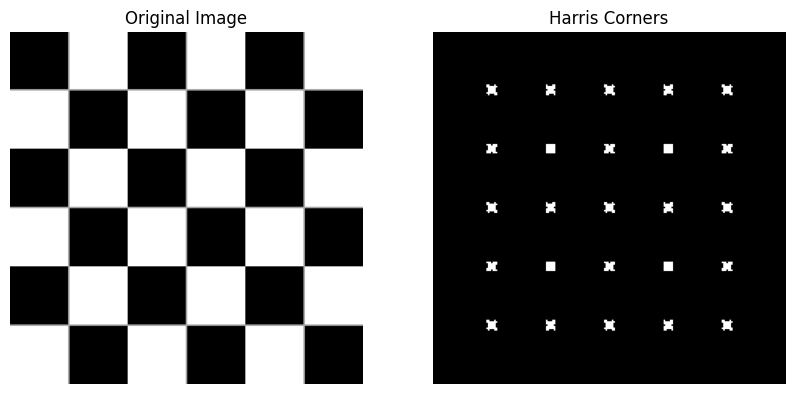

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/chessboard.png')

k=0.04
threshold=0.01

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# calculate gradients using Sobel filter
Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

# calculateproducts of gradients
Ixx = Ix * Ix
Iyy = Iy * Iy
Ixy = Ix * Iy

# Apply a Gaussian filter to the products of gradients
sigma = 1
Ixx = cv2.GaussianBlur(Ixx, (5, 5), sigma)
Iyy = cv2.GaussianBlur(Iyy, (5, 5), sigma)
Ixy = cv2.GaussianBlur(Ixy, (5, 5), sigma)

# Compute Harris corner response
det = (Ixx * Iyy) - (Ixy ** 2)
trace = Ixx + Iyy
R = det - k * (trace ** 2)

# Threshold for corner detection
corners = np.zeros_like(R)
corners[R > threshold * R.max()] = 255

# Display the original image and the detected corners using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(corners, cmap='gray')
plt.title('Harris Corners')
plt.axis('off')

plt.show()

# **Geometric feature extraction**

MSE = 70.93693923950195


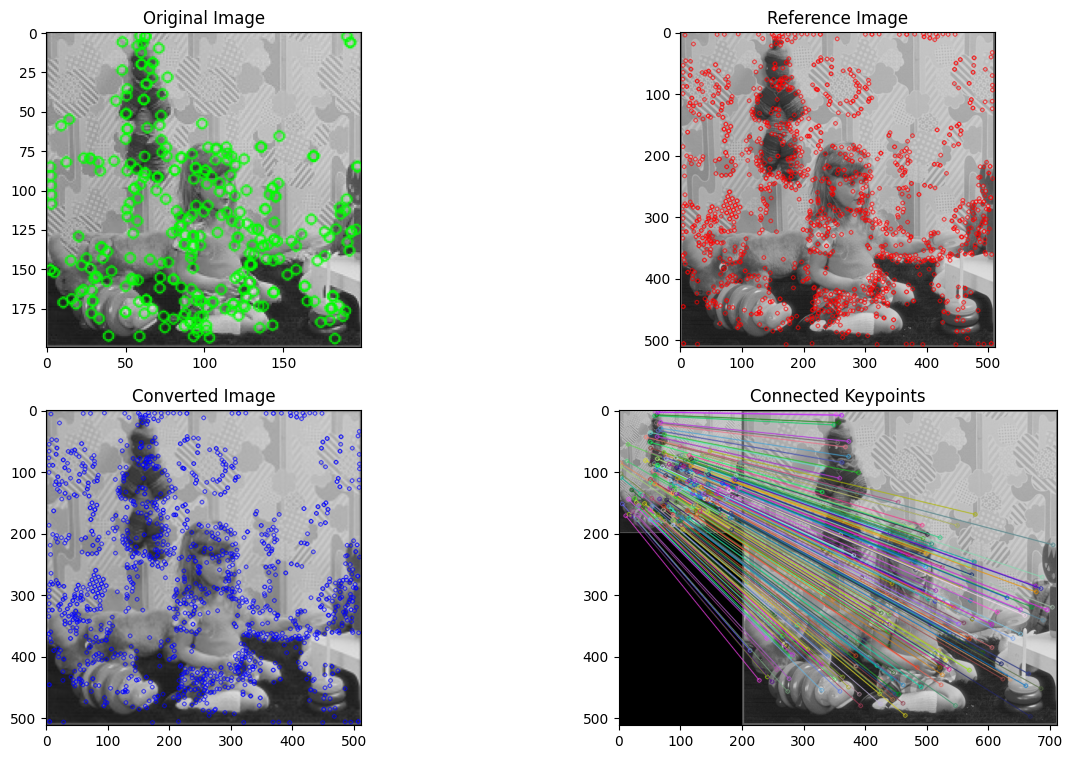

In [ ]:
im = cv2.imread(f'/content/drive/MyDrive/Image_Processing_Photos/d2.jpg', cv2.IMREAD_GRAYSCALE) # resize: d1.jpg

reference_img = cv2.imread('/content/drive/MyDrive/Image_Processing_Photos/d1.jpg', cv2.IMREAD_GRAYSCALE)

# Detection of points using algorithm
detector = cv2.SIFT_create()
# detector = cv2.BRISK_create()
# detector = cv2.ORB_create()
# detector = cv2.xfeatures2d.SURF_create()

pointsA, featuresA = detector.detectAndCompute(im, None)
pointsB, featuresB = detector.detectAndCompute(reference_img, None)

# Forming index pairs based on matching points
bf = cv2.BFMatcher()
indexPairs = bf.knnMatch(featuresA, featuresB, k=2)
goodMatches = []
for m, n in indexPairs:
    if m.distance < 0.75 * n.distance:
        goodMatches.append(m)

matchedPointsA = np.float32([pointsA[m.queryIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
matchedPointsB = np.float32([pointsB[m.trainIdx].pt for m in goodMatches]).reshape(-1, 1, 2)

# Estimation of transform using RANSAC algorithm
M, _ = cv2.findHomography(matchedPointsA, matchedPointsB, cv2.RANSAC, 5.0)
h, w = reference_img.shape
converted_img = cv2.warpPerspective(im, M, (w, h))

mse = mean_squared_error(converted_img, reference_img)
print(f"MSE = {mse}")

# Display special points on images
im_keypoints = cv2.drawKeypoints(im, pointsA, None, color=(0, 255, 0))
reference_keypoints = cv2.drawKeypoints(reference_img, pointsB, None, color=(255, 0, 0))
converted_keypoints = cv2.drawKeypoints(converted_img, pointsB, None, color=(0, 0, 255))

# each pair of keypoints is connected with a line
side_by_side_keypoints_connected = cv2.drawMatches(im, pointsA, reference_img, pointsB, goodMatches, None,
                                                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# cv2.imwrite('side_by_side_keypoints_connected.png', side_by_side_keypoints_connected)

plt.figure(figsize=(15, 9))

plt.subplot(2, 2, 1)
plt.imshow(im_keypoints, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(reference_keypoints, cmap='gray')
plt.title('Reference Image')

plt.subplot(2, 2, 3)
plt.imshow(converted_keypoints, cmap='gray')
plt.title('Converted Image')

plt.subplot(2, 2, 4)
plt.imshow(side_by_side_keypoints_connected, cmap='gray')
plt.title('Connected Keypoints')
plt.show()


# **Image stitching**

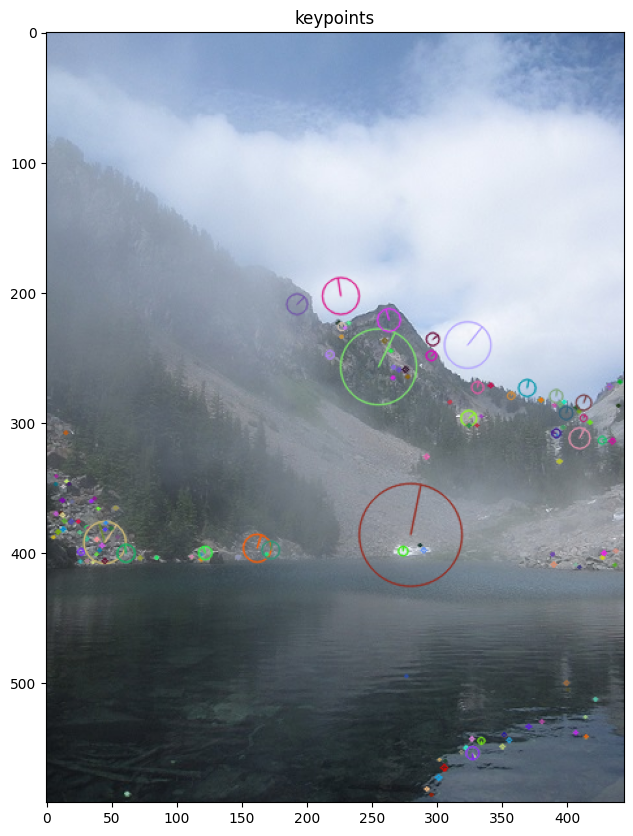

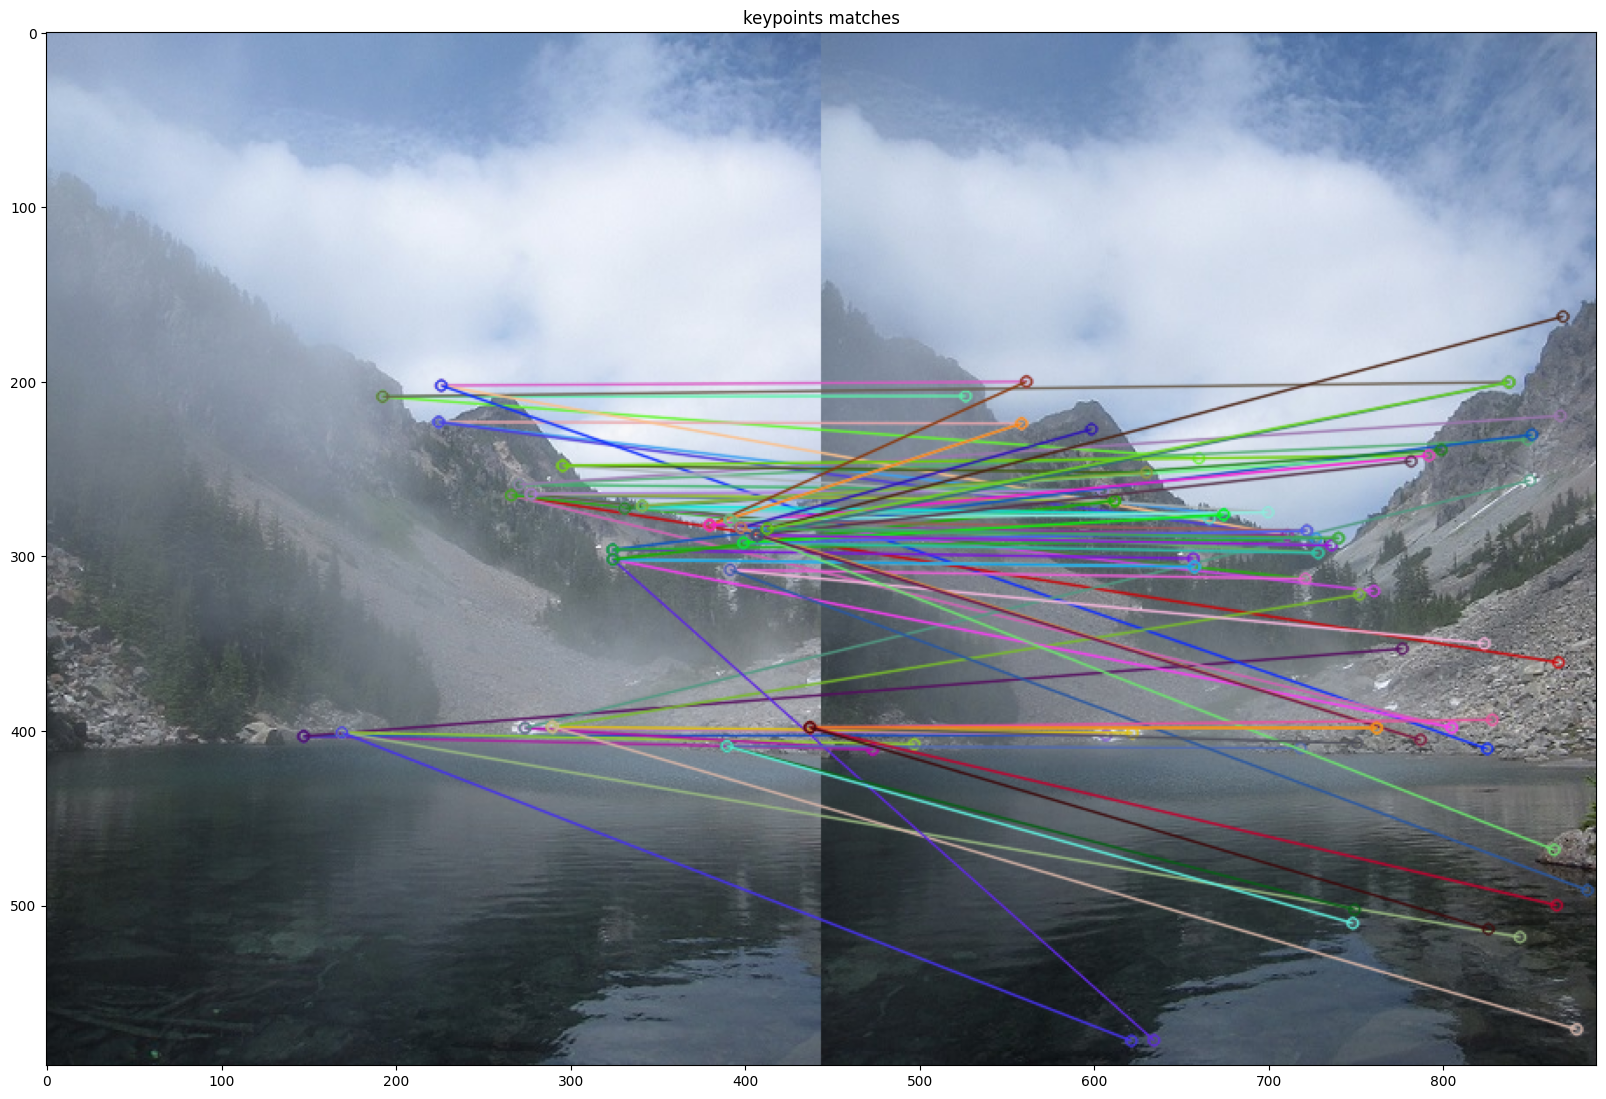

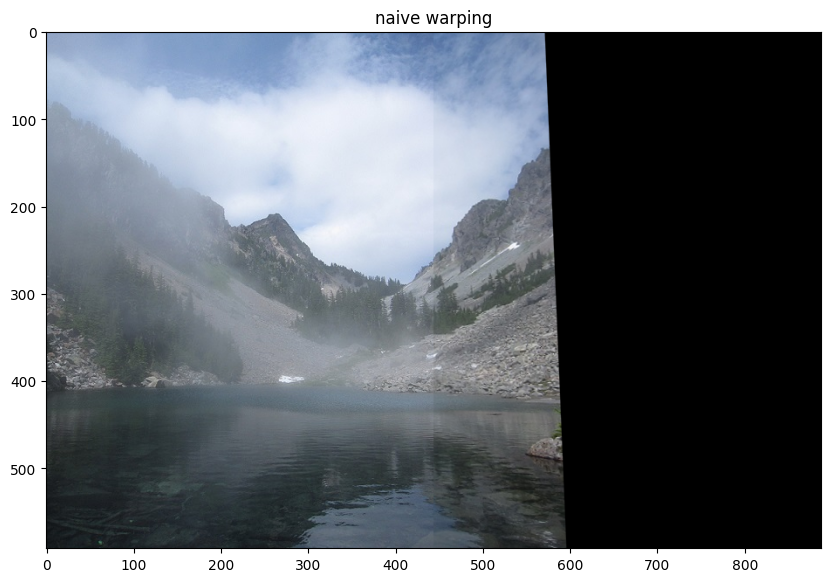

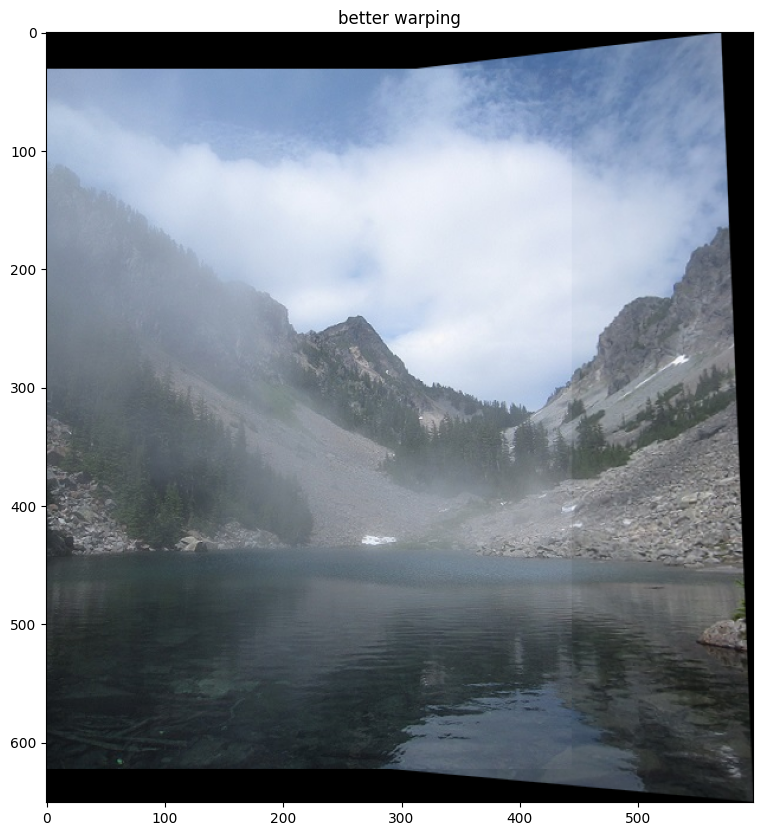

In [ ]:
rgb_l = cv2.cvtColor(cv2.imread("/content/drive/MyDrive/Image_Processing_Photos/k1.jpg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("/content/drive/MyDrive/Image_Processing_Photos/k2.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)

# use orb if sift is not installed
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)
#flags= parameter to control key points
test = cv2.drawKeypoints(rgb_l, kp_l, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10, 10))
plt.imshow(test)
plt.title("keypoints")
plt.show()
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=3)

# Apply ratio test
good_and_second_good_match_list = []
for m in matches:
    if m[0].distance/m[1].distance < 0.5:
        good_and_second_good_match_list.append(m)
good_match_arr = np.asarray(good_and_second_good_match_list)[:,0]

# show only 30 matches
im_matches = cv2.drawMatchesKnn(rgb_l, kp_l, rgb_r, kp_r,
                                good_and_second_good_match_list[0:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(im_matches)
plt.title("keypoints matches")
plt.show()

good_kp_l = np.array([kp_l[m.queryIdx].pt for m in good_match_arr])
good_kp_r = np.array([kp_r[m.trainIdx].pt for m in good_match_arr])
H, masked = cv2.findHomography(good_kp_r, good_kp_l, cv2.RANSAC, 5.0)


rgb_r_warped = cv2.warpPerspective(rgb_r, H, (rgb_l.shape[1] + rgb_r.shape[1], rgb_l.shape[0]))
rgb_r_warped[0:rgb_l.shape[0], 0:rgb_l.shape[1]] = rgb_l

plt.figure(figsize=(20,20))
plt.imshow(rgb_r_warped)
plt.title("naive warping")
plt.show()

def warpTwoImages(img1, img2, H):

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    result = cv2.warpPerspective(img2, Ht@H, (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = img1
    return result


result = warpTwoImages(rgb_l, rgb_r, H)

plt.figure(figsize=figsize)
plt.imshow(result)
plt.title("better warping")
plt.show()


# **Optical Flow**

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
def draw_optical_flow(flow, frame=None):
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 1] = 255  # Set saturation to maximum

    # Calculate flow magnitude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue corresponds to direction
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value corresponds to magnitude

    # Convert HSV to BGR for visualization
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr


def optical_flow_demo(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Cannot open video.")
        return

    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Cannot read the first frame.")
        return

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate dense optical flow using Farneback method
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None,
                                            pyr_scale=0.5, levels=3, winsize=15,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)

        # Visualize the optical flow
        flow_color = draw_optical_flow(flow, frame)
        cv2_imshow(flow_color)

        # Update previous frame
        prev_gray = gray

        if cv2.waitKey(20) & 0xFF == 27:  # Press 'ESC' to exit
            break

    cap.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    video_path = "test.mp4"
    optical_flow_demo(video_path)
